In [26]:
'''
    순서 
    (1) 데이터 로드
    (2) 데이터 info로 결측치 확인 -> 만약에 결측치 있으면 dropna나 fillna로 처리
    (3) heatmap 그리기
    (4) target값을 value_counts하여 빈도수 체크 -> (분류라면) train_test_split 시에 stratify 옵션 넣기
    (5) X, y 나누기
    (6) X를 StandardScaler로 정규화
    (7) train_test_split으로 X_train, X_test, y_train, y_test 만들기
    (8) 모든 classifier 동원하기
    (9) (성능이 좋지 않다면) PolynormialFeatures 도입하여 차수 늘린 후 다시 학습
'''

'\n    순서 \n    (1) 데이터 로드\n    (2) 데이터 info로 결측치 확인 -> 만약에 결측치 있으면 dropna나 fillna로 처리\n    (3) heatmap 그리기\n    (4) target값을 value_counts하여 빈도수 체크 -> (분류라면) train_test_split 시에 stratify 옵션 넣기\n    (5) X, y 나누기\n    (6) X를 StandardScaler로 정규화\n    (7) train_test_split으로 X_train, X_test, y_train, y_test 만들기\n    (8) random search\n    (9) (성능이 좋지 않다면) PolynormialFeatures 도입하여 차수 늘린 후 다시 random search\n'

In [27]:
'''
    나의 차선 전략 : random search
    
    회귀라면 : linear regression, lasso, ridge, 
            ElasticNet, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, 
            HistGradientBoostingRegressor
            
    분류라면 : SVC, logistic regression, decision tree, random forest,
            GradientBoostingClassifier, AdaBoostClassifier, GaussianNB, MLPClassifier,
            HistGradientBoostingClassifier
'''

param_dict_regression = {
    "LinearRegression": {}, 
    "Lasso": {
        "alpha": [0.01, 0.1, 1, 10],
        "max_iter": [100, 500, 1000]
    },
    "Ridge": {
        "alpha": [0.01, 0.1, 1, 10],
        "max_iter": [100, 500, 1000]
    },
    "ElasticNet": {
        "alpha": [0.01, 0.1, 1, 10],
        "l1_ratio": [0.1, 0.5, 0.9]
    },
    "RandomForestRegressor": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20]
    },
    "AdaBoostRegressor": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1],
        "algorithm": ["SAMME"]
    },
    "GradientBoostingRegressor": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "HistGradientBoostingRegressor": {
        "max_iter": [100, 200, 500],
        "learning_rate": [0.01, 0.1, 0.2]
    }
}

param_dict_classification = {
    "SVC": {
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", "auto"]
    },
    "LogisticRegression": {
        "C": [0.1, 1, 10, 100],
        "max_iter": [100, 200, 500]
    },
    "DecisionTreeClassifier": {
        "max_depth": [10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "RandomForestClassifier": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20]
    },
    "GradientBoostingClassifier": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "AdaBoostClassifier": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1],
        "algorithm": ["SAMME"]
    },
    "GaussianNB": {}, 
    "MLPClassifier": {
        "hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "max_iter" : [100, 200, 300]
    },
    "HistGradientBoostingClassifier": {
        "max_iter": [100, 200, 500],
        "learning_rate": [0.01, 0.1, 0.2]
    }
}


In [28]:
import numpy as np
import scipy as sci
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
header = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 
          'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
df = pd.read_csv("../../data/abalone/abalone.csv", names = header)
df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [31]:
df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


/tmp/ipykernel_589/3870688284.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

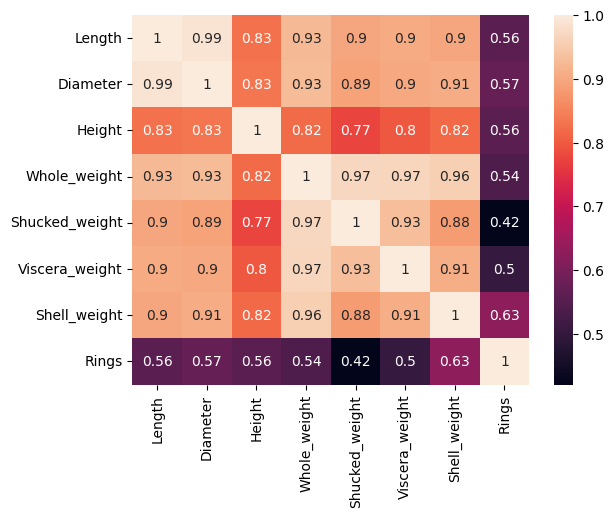

In [32]:
corr = df.corr()
sns.heatmap(corr, annot=True)

In [33]:
df['Rings'].value_counts()

9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
27      2
24      2
1       1
26      1
29      1
2       1
25      1
Name: Rings, dtype: int64

In [34]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder() 
df['Sex'] = LE.fit_transform(df['Sex'])
df['Rings'] = LE.fit_transform(df['Rings'])

df['Rings'].value_counts()

8     689
9     634
7     568
10    487
6     391
11    267
5     259
12    203
13    126
4     115
14    103
15     67
16     58
3      57
17     42
18     32
19     26
2      15
20     14
22      9
21      6
26      2
23      2
0       1
25      1
27      1
1       1
24      1
Name: Rings, dtype: int64

In [35]:
X, y = df[[feature for feature in df.columns if feature != 'Rings']], df['Rings']

print (X.shape, y.shape)

(4177, 8) (4177,)


In [39]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print (y_resampled.value_counts())

14    689
6     689
24    689
26    689
1     689
27    689
22    689
25    689
2     689
0     689
21    689
16    689
20    689
5     689
3     689
4     689
12    689
17    689
11    689
10    689
13    689
18    689
15    689
19    689
7     689
9     689
8     689
23    689
Name: Rings, dtype: int64


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2,
                                                    stratify=y_resampled)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(15433, 8) (15433,)
(3859, 8) (3859,)


In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score

def do_classification(X_train, X_test, y_train, y_test) :
    # KNN
    print ("KNN")
    best_knn = 0
    best_score = 0
    for i in range (1, 51) :
        KNN = KNeighborsClassifier(n_jobs=-1, n_neighbors=i)
        KNN.fit(X_train, y_train)
        y_pred_train = KNN.predict(X_train)
        y_pred_test = KNN.predict(X_test)
        acc_train = accuracy_score(y_train, y_pred_train)
        acc_test = accuracy_score(y_test, y_pred_test)
        print (f"{i} : train score : {acc_train}/ test score : {acc_test}")
        
        if i == 1 : 
            best_knn = KNN
            best_score = acc_test
            
        else : 
            if best_score <= acc_test : 
                best_knn = KNN
                best_score = acc_test
                
    print ("최종 KNN 결과 : ", best_score)
    print (classification_report(best_knn.predict(X_test), y_test))
           
    print ()
    # LR
    print ("LR")
    LR = LogisticRegression(max_iter=1000)
    LR.fit(X_train, y_train)
    y_pred_train = LR.predict(X_train)
    y_pred_test = LR.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    print (f"LR : train score : {acc_train}/ test score : {acc_test}")
    print (classification_report(y_pred_test, y_test))
           
    print ()
    # SGD
    print ("SGD")
    SGD = SGDClassifier(max_iter=1000)
    SGD.fit(X_train, y_train)
    y_pred_train = SGD.predict(X_train)
    y_pred_test = SGD.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    print (f"SGD : train score : {acc_train}/ test score : {acc_test}")
    print (classification_report(y_pred_test, y_test))
           
    print ()
    # DT
    print ("DT")
    DT = DecisionTreeClassifier(max_depth=10000, max_leaf_nodes=3000, max_features=7)
    DT.fit(X_train, y_train)
    y_pred_train = DT.predict(X_train)
    y_pred_test = DT.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    print (f"DT : train score : {acc_train}/ test score : {acc_test}")
    print (classification_report(y_pred_test, y_test))
           
    print ()
    # RF
    print ("RF")
    RF = RandomForestClassifier(max_depth=10000, max_leaf_nodes=3000, max_features=7)
    RF.fit(X_train, y_train)
    y_pred_train = RF.predict(X_train)
    y_pred_test = RF.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    print (f"RF : train score : {acc_train}/ test score : {acc_test}")
    print (classification_report(y_pred_test, y_test))
           
    print ()
    # adaboost
    print ("adaboost")
    adaboost = AdaBoostClassifier(algorithm="SAMME", 
                                  n_estimators=1000,
                                 learning_rate=0.001)
    adaboost.fit(X_train, y_train)
    y_pred_train = adaboost.predict(X_train)
    y_pred_test = adaboost.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    print (f"adaboost : train score : {acc_train}/ test score : {acc_test}")
    print (classification_report(y_pred_test, y_test))
           
    print ()
    # gradientboost
    print ("gradientboost")
    gradient = GradientBoostingClassifier(learning_rate=0.001, max_depth=10000,
                                         max_leaf_nodes=3000)
    gradient.fit(X_train, y_train)
    y_pred_train = gradient.predict(X_train)
    y_pred_test = gradient.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    print (f"gradient : train score : {acc_train}/ test score : {acc_test}")
    print (classification_report(y_pred_test, y_test))

do_classification(X_train, X_test, y_train, y_test)

KNN
1 : train score : 1.0/ test score : 0.8929774552993003
2 : train score : 0.954577852653405/ test score : 0.8691370821456336
3 : train score : 0.9206246355212856/ test score : 0.8442601710287639
4 : train score : 0.8978811637400376/ test score : 0.8292303705623219
5 : train score : 0.8781183178902352/ test score : 0.8116092251878725
6 : train score : 0.8617896714831854/ test score : 0.8033169214822493
7 : train score : 0.8439707121104127/ test score : 0.7851775071261985
8 : train score : 0.8304930992030065/ test score : 0.7727390515677637
9 : train score : 0.8227823495107885/ test score : 0.7680746307333506
10 : train score : 0.8096935138987883/ test score : 0.7577092511013216
11 : train score : 0.7996501004341346/ test score : 0.7470847369784919
12 : train score : 0.7930408864122336/ test score : 0.742161181653278
13 : train score : 0.7810535864705501/ test score : 0.7341280124384556
14 : train score : 0.7703622108468865/ test score : 0.7253174397512309
15 : train score : 0.7617443

/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SGD : train score : 0.29443400505410483/ test score : 0.29437678154962427
              precision    recall  f1-score   support

           0       1.00      0.81      0.90       169
           1       1.00      0.62      0.76       224
           2       0.14      0.45      0.21        42
           3       0.03      0.67      0.06         6
           4       0.77      0.31      0.44       346
           5       0.26      0.36      0.30       101
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.48      0.10      0.17       631
          11       0.00      0.00      0.00         0
          12       0.03      0.03      0.03       116
          13       0.00      0.00      0.00         0
          14       0.04      0.45      0.07        11
          15       0.00      0.00      0.00         0
       

/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RF : train score : 1.0/ test score : 0.8973827416429127
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00       138
           2       1.00      1.00      1.00       138
           3       1.00      0.99      0.99       140
           4       1.00      0.95      0.98       145
           5       0.90      0.88      0.89       141
           6       0.74      0.68      0.71       151
           7       0.44      0.49      0.46       125
           8       0.29      0.33      0.31       121
           9       0.27      0.45      0.33        83
          10       0.62      0.69      0.66       124
          11       0.92      0.85      0.89       149
          12       0.96      0.77      0.86       172
          13       0.99      0.94      0.96       144
          14       1.00      0.95      0.98       144
          15       1.00      0.99      1.00       139
          16       1.00  

/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


gradient : train score : 1.0/ test score : 0.8929774552993003
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       152
           1       1.00      1.00      1.00       138
           2       1.00      1.00      1.00       138
           3       1.00      0.99      1.00       139
           4       1.00      0.97      0.99       142
           5       0.86      0.84      0.85       141
           6       0.67      0.75      0.70       123
           7       0.46      0.56      0.51       114
           8       0.26      0.44      0.33        81
           9       0.31      0.51      0.39        84
          10       0.58      0.71      0.64       112
          11       0.92      0.81      0.86       156
          12       0.96      0.86      0.91       154
          13       0.99      0.94      0.96       145
          14       1.00      0.76      0.86       181
          15       1.00      0.97      0.98       143
          16       

In [55]:
from sklearn.preprocessing import PolynomialFeatures

PF = PolynomialFeatures(degree=3)
X_train_poly = PF.fit_transform(X_train)
X_test_poly = PF.transform(X_test)

print (X_train_poly.shape, X_test_poly.shape)

(15433, 165) (3859, 165)


In [57]:
do_classification(X_train_poly, X_test_poly,
                 y_train, y_test)

KNN
1 : train score : 1.0/ test score : 0.8958279346981083
2 : train score : 0.9538650942784941/ test score : 0.8699144856180357
3 : train score : 0.9208190241689885/ test score : 0.843223633065561
4 : train score : 0.8982051448195425/ test score : 0.8307851775071262
5 : train score : 0.879673427071859/ test score : 0.813941435605079
6 : train score : 0.8618544676990864/ test score : 0.8022803835190464
7 : train score : 0.8455258212920366/ test score : 0.7854366416169992
8 : train score : 0.8337977062139571/ test score : 0.7745529930033688
9 : train score : 0.8221343873517787/ test score : 0.7683337652241513
10 : train score : 0.812220566318927/ test score : 0.7618554029541332
11 : train score : 0.8020475604224713/ test score : 0.7520082923037056
12 : train score : 0.7924577204691245/ test score : 0.7457890645244882
13 : train score : 0.7792392924253224/ test score : 0.737496760818865
14 : train score : 0.767057603835936/ test score : 0.7279087846592381
15 : train score : 0.75882848441

/home/work/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR : train score : 0.47553942849737574/ test score : 0.4682560248769111
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       146
           1       1.00      0.61      0.76       227
           2       0.21      0.47      0.29        62
           3       0.48      0.47      0.48       139
           4       0.50      0.43      0.46       160
           5       0.34      0.31      0.32       154
           6       0.37      0.30      0.33       168
           7       0.31      0.21      0.25       208
           8       0.25      0.17      0.20       209
           9       0.07      0.17      0.10        59
          10       0.20      0.20      0.20       138
          11       0.10      0.12      0.11       115
          12       0.01      0.10      0.03        20
          13       0.09      0.22      0.13        60
          14       0.10      0.16      0.13        86
          15       0.11      0.17      0.13        90
         

/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RF : train score : 1.0/ test score : 0.8950505312257061
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00       138
           2       1.00      1.00      1.00       138
           3       1.00      0.99      0.99       140
           4       1.00      0.96      0.98       144
           5       0.86      0.85      0.86       140
           6       0.72      0.67      0.69       150
           7       0.49      0.48      0.48       141
           8       0.20      0.26      0.23       107
           9       0.27      0.40      0.32        93
          10       0.64      0.64      0.64       138
          11       0.93      0.84      0.88       152
          12       0.96      0.86      0.91       155
          13       0.99      0.94      0.96       144
          14       1.00      0.97      0.99       141
          15       1.00      0.99      0.99       140
          16       1.00  

/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyboardInterrupt: 